# Model Selection

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


Bad key "backend.qt4" on line 43 in
/etc/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
df = pd.read_csv('data/df.csv')

Removing Unnecessary Features

In [4]:
#df.dtypes

In [5]:
df = df[['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'channel', 'offer', 'conversion', 'score']]

In [6]:
#df = pd.get_dummies(df, columns = ['channel', 'offer'], drop_first=True)

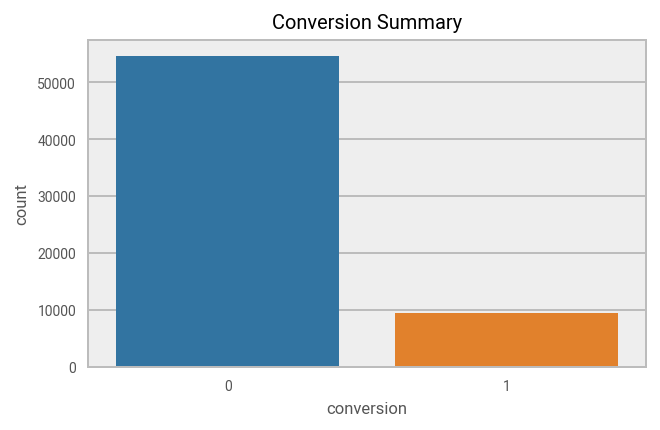

In [7]:
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(df.conversion, ax=ax).set_title('Conversion Summary')
plt.show()

In [8]:
!pip3 install imblearn
from imblearn.over_sampling import ADASYN, SMOTE

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

In [11]:
def models():
    
    models = {}
    models['log'] = (LogisticRegression(solver='lbfgs', n_jobs=-1), {'C':[0.01, 0.1, 1]})
    #models['ridge'] = (RidgeClassifier(), {'alpha':[0.01, 0.1, 1]})
    #models['rand_forest'] = (RandomForestClassifier(n_jobs=-1), {
    #                                                          'min_samples_split': [3, 5, 10], 
    #                                                          'n_estimators' : [100, 300],
    #                                                         'max_depth': [3, 5, 15, 25]
#})
    models['grad_boosting'] = (GradientBoostingClassifier(), {'learning_rate':[0.05, 0.1],
                                                               'min_samples_split':[5], 
                                                               'min_samples_leaf':[2, 5], 
                                                               'min_weight_fraction_leaf':[0.1, 0.5], 
                                                               'max_depth':[3, 5, 10]})
    return models

In [12]:
def processing_pipeline(numeric_features, categorical_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    #binary_transformer = Pipeline(steps=[
    #    ('imputer', SimpleImputer(strategy='most_frequent')),
    #    ('binary', Binarizer(threshold=0.5))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    #    ('bin', binary_transformer, bin_features)
    ])

    smt = ADASYN(n_jobs=-1, random_state=None, sampling_strategy='auto')
    
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', smt),
                          ('clf', classifier)])

    return pipe

In [13]:
def split_data(df, target_name, test_size):
    
    y = df[target_name]
    X = df.drop(target_name, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

In [14]:
def evaluate_classifier(X_train, X_test, y_train, y_test, pipe, classifier_paramgrid, metric):
    
    #NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV
    
    classifier, param_grid = classifier_paramgrid[0], classifier_paramgrid[1]
    
    new_param_grid = {}
    for i,k in param_grid.items(): 
        j = 'clf__'+i
        new_param_grid[j] = k
    
    #Using stratified kfold to address imbalanced classes in target feature:
    cv = StratifiedKFold(n_splits=5)
    
    gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=1, cv=cv, scoring=metric)
    
    gs.fit(X_train, y_train)
    
    cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)
    
    print("\n---------")
    print("Model Evaluated: ", classifier_paramgrid[0])
    print("Training {} Mean with CV: {}".format(metric, cv_metric.mean()))
    print("Training {} Standard Dev with CV: {}".format(metric, cv_metric.std()))
    print("Test Score: %.3f" % gs.score(X_test, y_test))
    
    return cv_metric

In [15]:
def execute_spotcheck(df, target_name, test_size, numeric_features, categorical_features):
    
    #Split the data so to leave a final test set to avoid data leakage
    X_train, X_test, y_train, y_test = split_data(df, target_name, test_size)
    
    #Create a dictionary holding models that will be evaluated
    models_tested = models()
    
    model_results = {}
    
    for k, (model, params) in models_tested.items():
        #Create pipeline to apply the same transformations to each model evaluated
        pipe = processing_pipeline(numeric_features, categorical_features, model)
        cv_metric = evaluate_classifier(X_train, X_test, y_train, y_test, pipe, (model, params), 'recall')
        model_results[k] = cv_metric
        
    return model_results

In [16]:
def visualize_results(models_report):
    fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
    sns.boxplot(data=models_report, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

In [17]:
numeric_features = list(df.select_dtypes(include=['int', 'float']).columns)
categorical_features = list(df.select_dtypes(exclude=['int', 'float']).columns)

In [18]:
numeric_features.remove('conversion')

In [19]:
model_results = execute_spotcheck(df, 'conversion', 0.2, numeric_features, categorical_features)


---------
Model Evaluated:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Training recall Mean with CV: 0.9358616101131071
Training recall Standard Dev with CV: 0.0059598657821846165
Test Score: 0.934

---------
Model Evaluated:  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=Non

In [20]:
models_report = pd.DataFrame(model_results, columns=list(models().keys()))

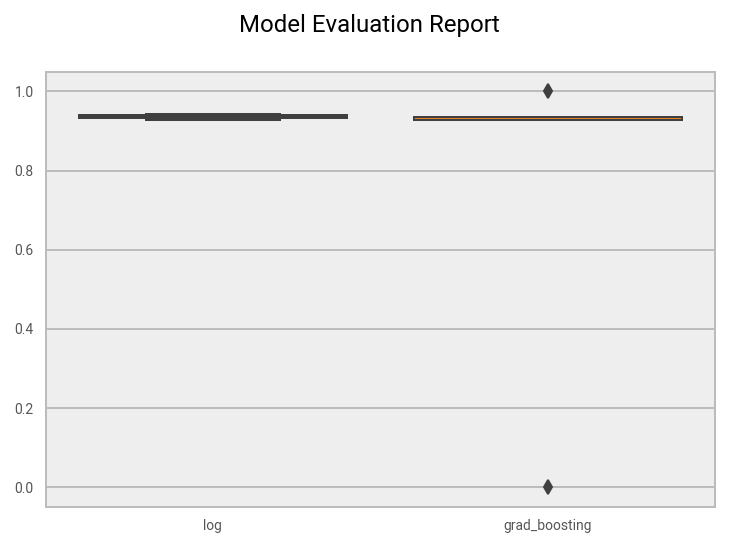

In [21]:
visualize_results(models_report)

In [22]:
!pip3 install yellowbrick

You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [24]:
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10)

In [25]:
X_train, X_test, y_train, y_test = split_data(df, 'conversion', 0.2)

In [26]:
best_log = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
best_gb = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [28]:
pipe_log = processing_pipeline(numeric_features, categorical_features, best_log)

In [29]:
pipe_gb = processing_pipeline(numeric_features, categorical_features, best_gb)

Visualizing Results

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


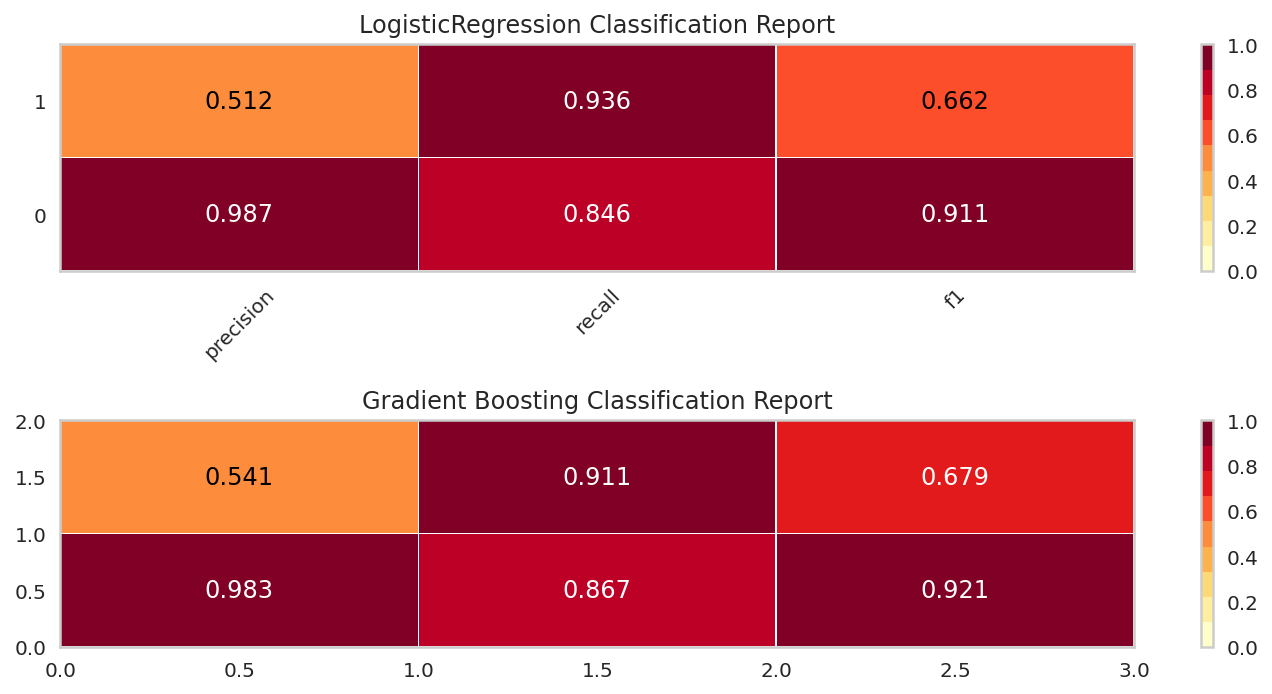

In [30]:
fig, axes = plt.subplots(2,1,figsize=(10,5))

cr_log = ClassificationReport(pipe_log, ax=axes[0], classes=['0', '1'])
cr_log.fit(X_train, y_train)
cr_log.score(X_test, y_test)

cr_gb = ClassificationReport(pipe_gb, ax=axes[1], classes=['0', '1'])
cr_gb.fit(X_train, y_train)
cr_gb.score(X_test, y_test)

axes[0].set(title='Log Regression Classification Report')
axes[1].set(title='Gradient Boosting Classification Report')

cr_log.poof()
#cr_gb.poof()
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


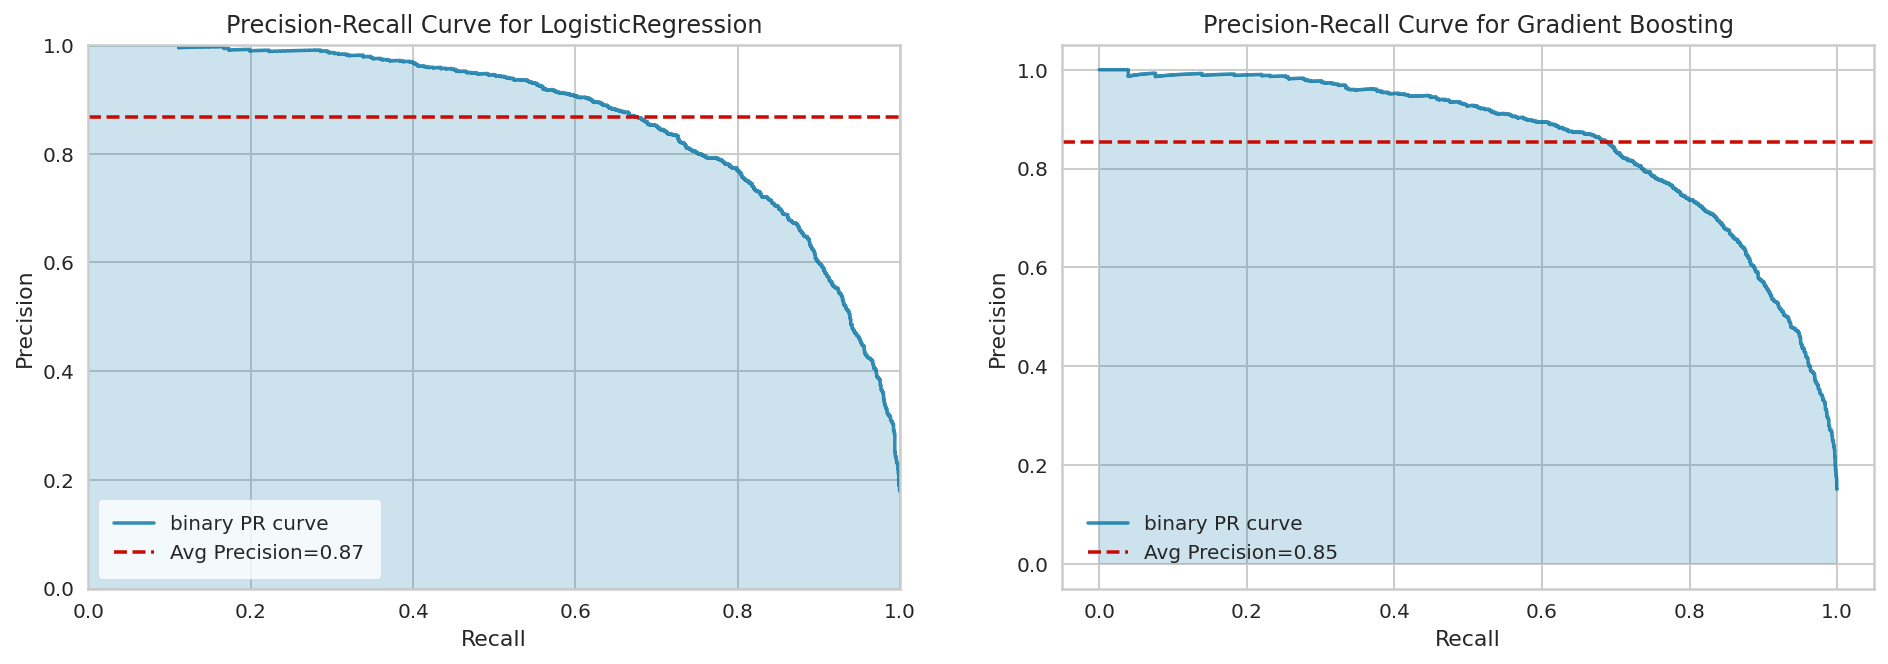

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(16,5))

viz_pc_log = PrecisionRecallCurve(pipe_log, ax=axes[0])
viz_pc_log.fit(X_train, y_train)
viz_pc_log.score(X_test, y_test)

viz_pc_gb = PrecisionRecallCurve(pipe_gb, ax=axes[1])
viz_pc_gb.fit(X_train, y_train)
viz_pc_gb.score(X_test, y_test)

axes[0].set(title='Precision-Recall Curve for Log Regression', xlabel='Recall', ylabel='Precision')
axes[1].set(title='Precision-Recall Curve for Gradient Boosting', xlabel='Recall', ylabel='Precision')
axes[0].legend().set_visible(True)
axes[1].legend().set_visible(True)

viz_pc_log.poof()
viz_pc_gb.poof()
plt.show()

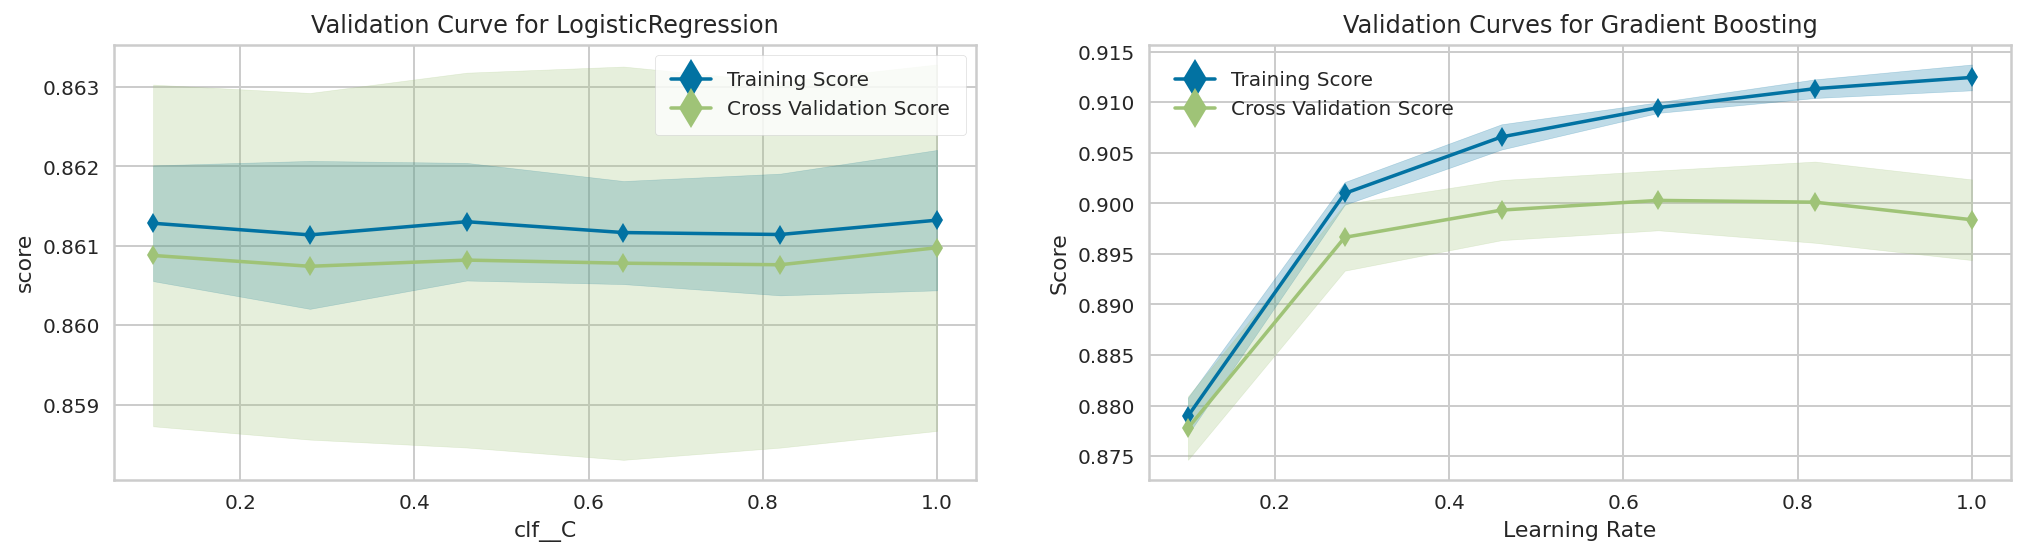

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

viz_vc_log = ValidationCurve(
    pipe_log, param_name="clf__C",
    param_range=np.linspace(0.1,1, 6), cv=cv, scoring="accuracy", ax=axes[0])

viz_vc_log.fit(X_train, y_train)

viz_vc_gb = ValidationCurve(
    pipe_gb, param_name="clf__learning_rate",
    param_range=np.linspace(0.1,1, 6), cv=cv, scoring="accuracy", ax=axes[1])

viz_vc_gb.fit(X_train, y_train)

axes[0].set(title='Validation Curves for GBM', xlabel='C', ylabel='Score')
axes[1].set(title='Validation Curves for Gradient Boosting', xlabel='Learning Rate', ylabel='Score')
axes[0].legend().set_visible(True)
axes[1].legend().set_visible(True)

viz_vc_log.poof()
viz_vc_gb.poof()
plt.show()

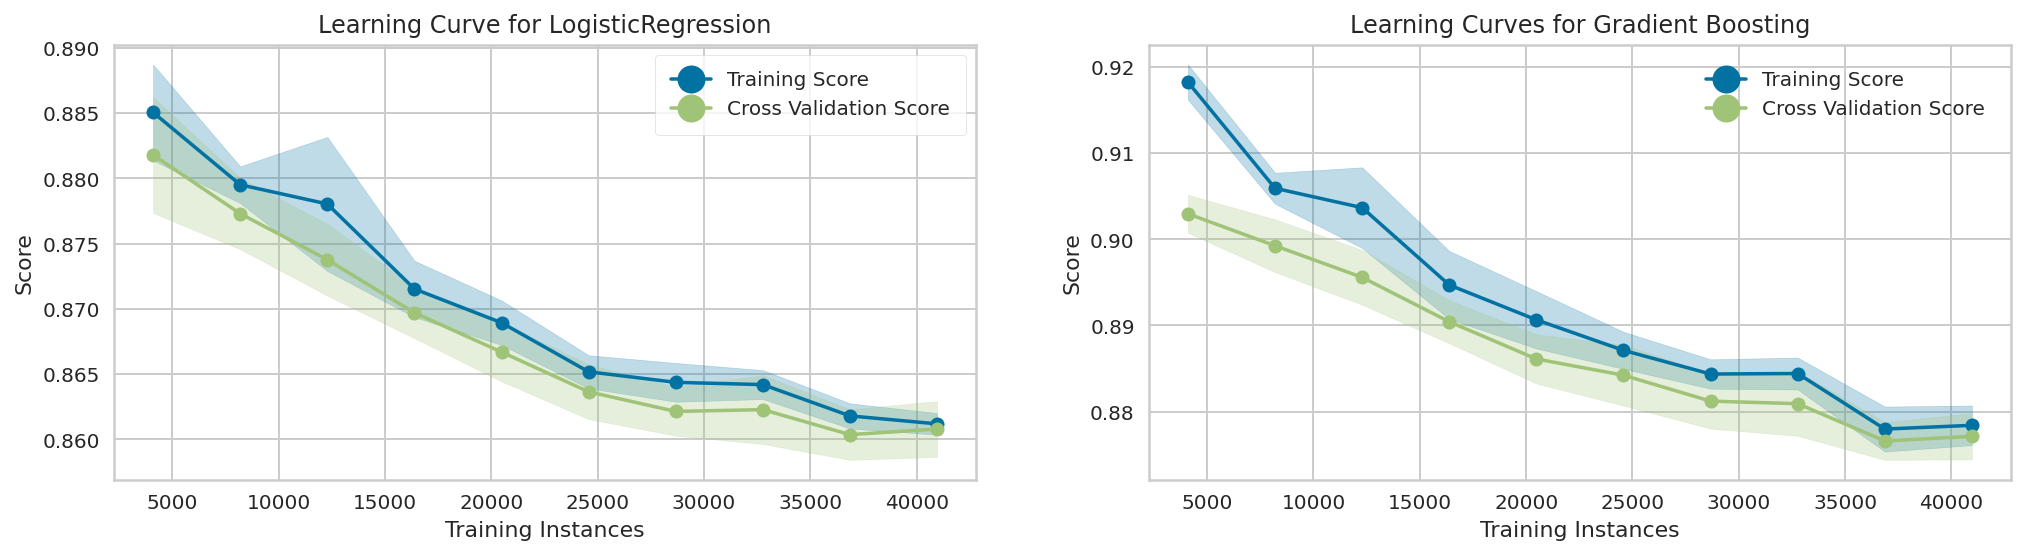

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

viz_lc_log = LearningCurve(
    pipe_log, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[0]
)
# Fit and poof the visualizer
viz_lc_log.fit(X_train, y_train)

viz_lc_gb = LearningCurve(
    pipe_gb, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[1]
)
# Fit and poof the visualizer
viz_lc_gb.fit(X_train, y_train)

axes[0].set(title='Learning Curves for Log Regression', xlabel='Training Instances', ylabel='Score')
axes[1].set(title='Learning Curves for Gradient Boosting', xlabel='Training Instances', ylabel='Score')
axes[0].legend().set_visible(True)
axes[1].legend().set_visible(True)

viz_lc_log.poof()
viz_lc_gb.poof()
plt.show()

In [34]:
import pickle

In [35]:
# save the model to disk
filename = 'models/development_model.sav'
pickle.dump(pipe_gb, open(filename, 'wb'))

#### Writing data to local 

In [36]:
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False) 
pd.DataFrame(y_train).to_csv('data/y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('data/y_test.csv', index=False)

#### Writing data to Hive Managed Table 

In [37]:
from pyspark.sql import SparkSession

In [ ]:
#spark = SparkSession\
#    .builder\
#    .appName("MarketingData")\
#    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
#    .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-2/")\
#    .getOrCreate()

In [ ]:
spark_df = spark.createDataFrame(df)

In [ ]:
spark_df\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.customer_data'
)